In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import scipy.optimize as spo
from functools import reduce
import pandas_datareader.data as web # make sure to have the newest pandas-datareader module installed
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import scipy.linalg as lg
%matplotlib inline  
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = [8,4]

plt.rcParams['axes.grid'] = True
# to avoid some stupid error
import yfinance as yfin
yfin.pdr_override()

In [2]:
#Wczytywanie danych
start = datetime.datetime(2018, 12, 30)
end =   datetime.datetime(2022, 12, 30)
df = web.DataReader("GLD", start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,120.980003,121.260002,120.830002,121.250000,121.250000,8449400
2019-01-02,121.349998,121.750000,120.879997,121.330002,121.330002,12776200
2019-01-03,121.779999,122.459999,121.730003,122.430000,122.430000,15440800
2019-01-04,121.320000,121.599998,120.690002,121.440002,121.440002,13334000
2019-01-07,122.160004,122.220001,121.570000,121.860001,121.860001,7473600
...,...,...,...,...,...,...
2022-12-22,167.759995,167.759995,166.059998,166.759995,166.759995,5672700
2022-12-23,166.880005,167.800003,166.660004,167.259995,167.259995,2912300
2022-12-27,167.889999,170.610001,167.800003,168.669998,168.669998,6885700


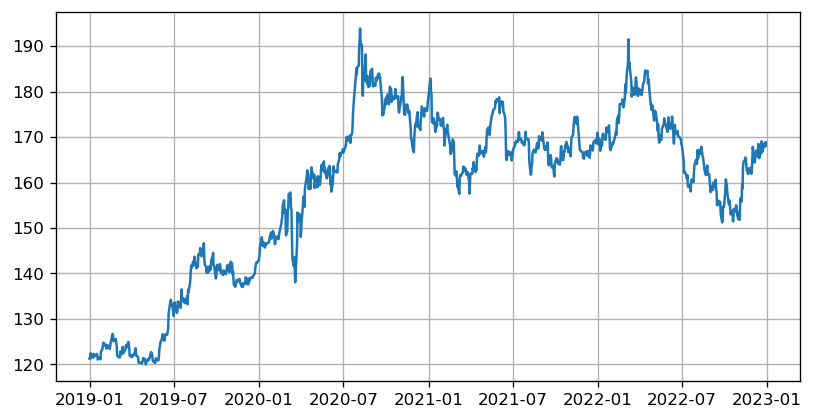

In [4]:
adj_close=df['Adj Close']
adj_close_norm=adj_close

plt.plot(adj_close_norm)

In [5]:
adj_close[-1]

168.85000610351562

analysis for: 0.000375 ± 0.009634


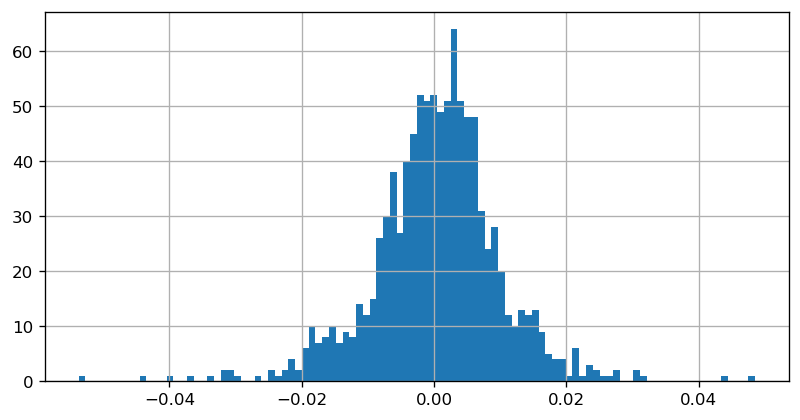

In [6]:
returns = adj_close_norm.pct_change()
plt.hist(returns, bins=100);
mean=np.mean(returns)
var=np.var(returns)
print(f'analysis for: {mean:.6f} ± {np.sqrt(var):.6f}')

In [7]:
rfr = pdr.DataReader("DGS10", "fred", datetime.datetime(2022, 12, 28) )
rfr


,DGS10
DATE,
2022-12-28,3.88
2022-12-29,3.83
2022-12-30,3.88
2023-01-02,NaN
2023-01-03,3.79
...,...
2024-02-12,4.17
2024-02-13,4.31
2024-02-14,4.27


In [8]:
r_rel=rfr.loc[df.index[-1]][0]


sigma=np.sqrt(var*250)
print(r_rel)

3.83


In [9]:
def call(t,S,X,r,sigma,T):
    d=(np.log(S/X)+(r+(sigma**2)/2)*(T-t))/(sigma*np.sqrt(T-t))
    C= S*stats.norm.cdf(d)-X*np.exp(-r*(T-t))*stats.norm.cdf(d-sigma*np.sqrt(T-t))
    return C

In [10]:

call(0,169,180,r_rel/100,sigma,1)

8.406898207007004

In [11]:
#Monte Carlo
#Black-Sholes model dS=S*mu*dt+S*sigma*dW

mu=mean
sigma=np.sqrt(var)

dw=np.random.randn(100000,250)
ds=np.log(1+mu+sigma*dw)
cS=np.exp(np.cumsum(ds,axis=1))*169






In [12]:
cS.T[-1]
call_mc=np.mean(np.maximum(cS.T[-1]-180,0))*np.exp(-r_rel/100)
print(call_mc)

13.627989519286869


In [13]:
def M_1(lamb,x,sigma,h,r):
    return -1*(lamb*x*x*sigma*sigma-h*lamb*x*r)/(4*h)
#element n
def M(lamb,x,sigma,h,r):
    return 1+lamb*h*(r+x*x*sigma*sigma/(h*h))/2
#element n+1
def M_2(lamb,x,sigma,h,r):
    return -1*(lamb*x*x*sigma*sigma+h*lamb*x*r)/(4*h)


#Macierz B
#element n-1
def B_1(lamb,x,sigma,h,r):
    return (lamb*x*x*sigma*sigma-h*lamb*x*r)/(4*h)
#element n
def B(lamb,x,sigma,h,r):
    return 1-lamb*h*(r+x*x*sigma*sigma/(h*h))/2
#element n+1
def B_2(lamb,x,sigma,h,r):
    return (lamb*x*x*sigma*sigma+h*lamb*x*r)/(4*h)


def CN_BS(deltat,deltax,x_0,sigma,r,T):
    h=deltax
    lamb=deltat/h

    

    M_matrix = np.array([M_2(lamb,x_0,sigma,h,r), M(lamb,x_0,sigma,h,r), M_1(lamb,x_0,sigma,h,r)])
     
    M_matrix[1, 0] = 1  
    M_matrix[0, 1] = 0  
    M_matrix[1, -1] = 1 
    M_matrix[2, -2] = 0 

    
    Bp=B_2(lamb,x_0,sigma,h,r)
    B0=B(lamb,x_0,sigma,h,r)
    Bm=B_1(lamb,x_0,sigma,h,r)
    

    
    #tutaj wstaw rodzaj opcji
    v_T=np.maximum(x_0-180,0)
    
    res = [v_T]
    Bn = np.empty_like(v_T)
    Bn[1:-1]=Bp[2:]*v_T[2:]+B0[1:-1]*v_T[1:-1]+Bm[:-2]*v_T[:-2]
    Bn[0]=v_T[0]
    Bn[-1]=v_T[-1]
    for n in range(int(T/deltat)):
        u = lg.solve_banded((1,1), M_matrix, Bn);
        u[0]=0
        u[-1]=x_0[-1]-180*np.exp(-r*(T-deltat*n))
        Bn[1:-1]=Bp[2:]*u[2:]+B0[1:-1]*u[1:-1]+Bm[:-2]*u[:-2]
        Bn[0]=u[0]
        Bn[-1]=u[-1]
        res.append(u)
    return np.array(res).T


In [14]:
deltat=1/250
deltax=1
sigma=np.sqrt(var*250)
r=r_rel/100
T=1
x_0=np.linspace(0,400,401)
h=deltax
lamb=deltat/h

wynik = CN_BS(deltat,deltax,x_0,sigma,r,T)
s=wynik.T

    
print(s[-1][169])

13.434173866330774


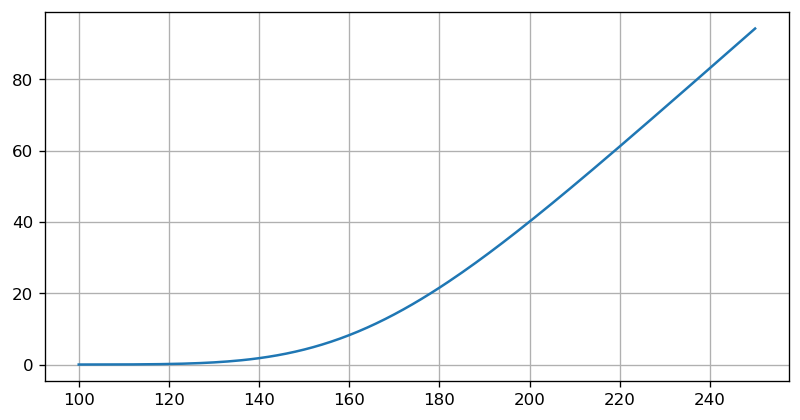

In [15]:
plt.plot(np.linspace(100,250,151),s[-1][100:251])

In [16]:
#MC barrier option up-and-out
mu=mean
sigma=np.sqrt(var)

dw=np.random.randn(100000,250)
ds=np.log(1+mu+sigma*dw)
cS=np.exp(np.cumsum(ds,axis=1))*169

In [17]:
for i in range(100000):
    if(np.max(cS[i])>190):
        cS[i][-1]=0

In [18]:
call_uao_mc=np.mean(np.maximum(cS.T[-1]-180,0))*np.exp(-r_rel/100)
print(call_uao_mc)

0.14166299491294507


In [19]:
def M_1(lamb,x,sigma,h,r):
    return -1*(lamb*x*x*sigma*sigma-h*lamb*x*r)/(4*h)
#element n
def M(lamb,x,sigma,h,r):
    return 1+lamb*h*(r+x*x*sigma*sigma/(h*h))/2
#element n+1
def M_2(lamb,x,sigma,h,r):
    return -1*(lamb*x*x*sigma*sigma+h*lamb*x*r)/(4*h)


#Macierz B
#element n-1
def B_1(lamb,x,sigma,h,r):
    return (lamb*x*x*sigma*sigma-h*lamb*x*r)/(4*h)
#element n
def B(lamb,x,sigma,h,r):
    return 1-lamb*h*(r+x*x*sigma*sigma/(h*h))/2
#element n+1
def B_2(lamb,x,sigma,h,r):
    return (lamb*x*x*sigma*sigma+h*lamb*x*r)/(4*h)


def CN_BS_uao(deltat,deltax,x_0,sigma,r,T):
    h=deltax
    lamb=deltat/h

    

    M_matrix = np.array([M_2(lamb,x_0,sigma,h,r), M(lamb,x_0,sigma,h,r), M_1(lamb,x_0,sigma,h,r)])
     
    M_matrix[1, 0] = 1  
    M_matrix[0, 1] = 0  
    M_matrix[1, -1] = 1 
    M_matrix[2, -2] = 0 

    
    Bp=B_2(lamb,x_0,sigma,h,r)
    B0=B(lamb,x_0,sigma,h,r)
    Bm=B_1(lamb,x_0,sigma,h,r)
    

    
    #tutaj wstaw rodzaj opcji
    v_T=np.maximum(x_0-180,0)
    
    res = [v_T]
    Bn = np.empty_like(v_T)
    Bn[1:-1]=Bp[2:]*v_T[2:]+B0[1:-1]*v_T[1:-1]+Bm[:-2]*v_T[:-2]
    Bn[0]=v_T[0]
    Bn[-1]=v_T[-1]
    for n in range(int(T/deltat)):
        u = lg.solve_banded((1,1), M_matrix, Bn);
        u[0]=0
        #u[-1]=x_0[-1]-180*np.exp(-r*(T-deltat*n))
        u[190:]=0
        Bn[1:-1]=Bp[2:]*u[2:]+B0[1:-1]*u[1:-1]+Bm[:-2]*u[:-2]
        Bn[0]=u[0]
        Bn[-1]=u[-1]
        res.append(u)
    return np.array(res).T


0.14251976014131604


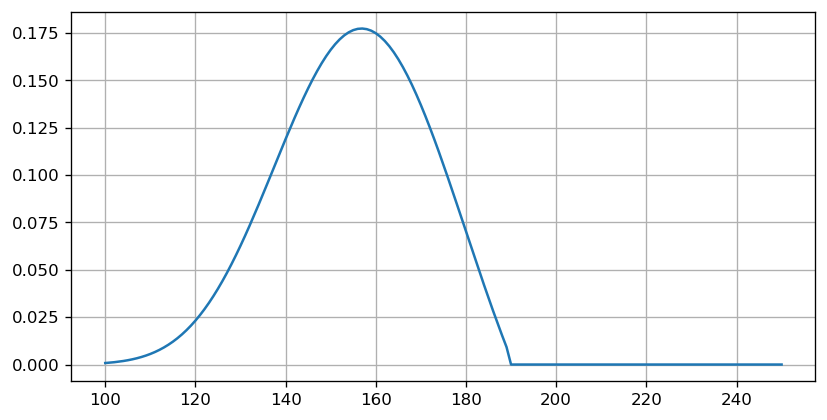

In [20]:
deltat=1/250
deltax=1
sigma=np.sqrt(var*250)
r=r_rel/100
T=1
x_0=np.linspace(0,400,401)
h=deltax
lamb=deltat/h

wynik = CN_BS_uao(deltat,deltax,x_0,sigma,r,T)
s=wynik.T

print(s[-1][169])   
plt.plot(np.linspace(100,250,151),s[-1][100:251])

In [21]:
#MC barrier option down-and-in
mu=mean
sigma=np.sqrt(var)

dw=np.random.randn(100000,250)
ds=np.log(1+mu+sigma*dw)
cS=np.exp(np.cumsum(ds,axis=1))*169

In [22]:
for i in range(100000):
    if(np.min(cS[i])>165):
        cS[i][-1]=0

In [23]:
call_dai_mc=np.mean(np.maximum(cS.T[-1]-180,0))*np.exp(-r_rel/100)
print(call_dai_mc)

6.56625804510044


In [24]:
def M_1(lamb,x,sigma,h,r):
    return -1*(lamb*x*x*sigma*sigma-h*lamb*x*r)/(4*h)
#element n
def M(lamb,x,sigma,h,r):
    return 1+lamb*h*(r+x*x*sigma*sigma/(h*h))/2
#element n+1
def M_2(lamb,x,sigma,h,r):
    return -1*(lamb*x*x*sigma*sigma+h*lamb*x*r)/(4*h)


#Macierz B
#element n-1
def B_1(lamb,x,sigma,h,r):
    return (lamb*x*x*sigma*sigma-h*lamb*x*r)/(4*h)
#element n
def B(lamb,x,sigma,h,r):
    return 1-lamb*h*(r+x*x*sigma*sigma/(h*h))/2
#element n+1
def B_2(lamb,x,sigma,h,r):
    return (lamb*x*x*sigma*sigma+h*lamb*x*r)/(4*h)

def CN_BS(deltat,deltax,x_0,sigma,r,T):
    h=deltax
    lamb=deltat/h

    

    M_matrix = np.array([M_2(lamb,x_0,sigma,h,r), M(lamb,x_0,sigma,h,r), M_1(lamb,x_0,sigma,h,r)])
     
    M_matrix[1, 0] = 1  
    M_matrix[0, 1] = 0  
    M_matrix[1, -1] = 1 
    M_matrix[2, -2] = 0 

    
    Bp=B_2(lamb,x_0,sigma,h,r)
    B0=B(lamb,x_0,sigma,h,r)
    Bm=B_1(lamb,x_0,sigma,h,r)
    

    
    #tutaj wstaw rodzaj opcji
    v_T=np.maximum(x_0-180,0)
    
    res = [v_T]
    Bn = np.empty_like(v_T)
    Bn[1:-1]=Bp[2:]*v_T[2:]+B0[1:-1]*v_T[1:-1]+Bm[:-2]*v_T[:-2]
    Bn[0]=v_T[0]
    Bn[-1]=v_T[-1]
    for n in range(int(T/deltat)):
        u = lg.solve_banded((1,1), M_matrix, Bn);
        u[0]=0
        u[-1]=x_0[-1]-180*np.exp(-r*(T-deltat*n))
        Bn[1:-1]=Bp[2:]*u[2:]+B0[1:-1]*u[1:-1]+Bm[:-2]*u[:-2]
        Bn[0]=u[0]
        Bn[-1]=u[-1]
        res.append(u)
    return np.array(res).T
def CN_BS_dai(deltat,deltax,x_0,sigma,r,T):
    h=deltax
    lamb=deltat/h

    wynik = CN_BS(deltat,deltax,x_0,sigma,r,T)
    s=wynik.T

    M_matrix = np.array([M_2(lamb,x_0,sigma,h,r), M(lamb,x_0,sigma,h,r), M_1(lamb,x_0,sigma,h,r)])
     
    M_matrix[1, 0] = 1  
    M_matrix[0, 1] = 0  
    M_matrix[1, -1] = 1 
    M_matrix[2, -2] = 0 

    
    Bp=B_2(lamb,x_0,sigma,h,r)
    B0=B(lamb,x_0,sigma,h,r)
    Bm=B_1(lamb,x_0,sigma,h,r)
    

    
    #tutaj wstaw rodzaj opcji
    #v_T=np.maximum(x_0-180,0)
    v_T=np.zeros_like(x_0)
    
    
    res = [v_T]
    Bn = np.empty_like(v_T)
    Bn[1:-1]=Bp[2:]*v_T[2:]+B0[1:-1]*v_T[1:-1]+Bm[:-2]*v_T[:-2]
    Bn[0]=v_T[0]
    Bn[-1]=v_T[-1]
    for n in range(int(T/deltat)):
        u = lg.solve_banded((1,1), M_matrix, Bn);
        u[0]=0
        u[-1]=0
        u[:165]=s[n+1][:165]
        Bn[1:-1]=Bp[2:]*u[2:]+B0[1:-1]*u[1:-1]+Bm[:-2]*u[:-2]
        Bn[0]=u[0]
        Bn[-1]=u[-1]
        res.append(u)
    return np.array(res).T

6.062896039384492


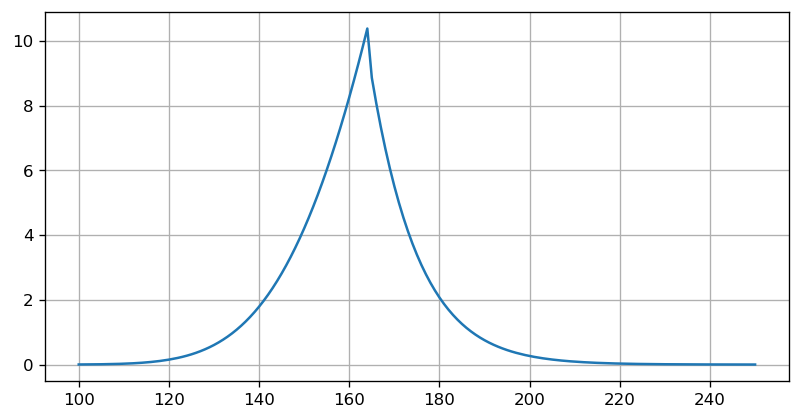

In [28]:
deltat=1/250
deltax=1
sigma=np.sqrt(var*250)
r=r_rel/100
T=1
x_0=np.linspace(0,400,401)
h=deltax
lamb=deltat/h

wynik = CN_BS_dai(deltat,deltax,x_0,sigma,r,T)
s=wynik.T

print(s[-1][169])   
plt.plot(np.linspace(100,250,151),s[-1][100:251])